In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.9.1 anndata==0.7.6 umap==0.5.1 numpy==1.22.4 scipy==1.6.2 pandas==1.4.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.11 pynndescent==0.5.2


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [3]:
adata = sc.read_h5ad('h5ad/df.fil3_gex_bcells_no_CLL_vdj.h5ad')
adata

AnnData object with n_obs × n_vars = 70501 × 318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [4]:
# keep to good cells
adata = adata[(adata.obs['merged_souporcell_status'] == 'singlet') & (adata.obs['celltype_B_corrected'] != 'doublet') & (adata.obs['sample_id'] != 'NA') & (~adata.obs['patient_id'].isin(['NULL', 'unresolved']))].copy()
adata

AnnData object with n_obs × n_vars = 58436 × 318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [5]:
# calculate days to sampling, days to admission, days to first symptoms, days to discharge from positive swab
tmp = adata.copy()
tmp.obs['sample_date'] = tmp.obs['sample_date'].astype('object')
tmp.obs['date_first_symptoms'] = tmp.obs['date_first_symptoms'].astype('object')
tmp.obs['date_positive_swab'] = tmp.obs['date_positive_swab'].astype('object')
tmp.obs['date_first_symptoms'].replace({'NA':np.nan}, inplace = True)
tmp.obs['date_positive_swab'].replace({'NA':np.nan}, inplace = True)
time_from_first_symptoms = pd.to_datetime(tmp.obs['sample_date'], format='%d/%m/%Y') - pd.to_datetime(tmp.obs['date_first_symptoms'], format='%d/%m/%Y')
time_from_positive_swab = pd.to_datetime(tmp.obs['sample_date'], format='%d/%m/%Y') - pd.to_datetime(tmp.obs['date_positive_swab'], format='%d/%m/%Y')
days_from_first_symptoms = time_from_first_symptoms.dt.days
days_from_positive_swab = time_from_positive_swab.dt.days
days_from_first_symptoms.fillna(0, inplace = True)
days_from_positive_swab.fillna(0, inplace = True)
days_from_infection = [max(a,b) for a,b in zip(days_from_first_symptoms, days_from_positive_swab)]
adata.obs['time_from_first_symptoms'] = days_from_first_symptoms
adata.obs['time_from_positive_swab'] = days_from_positive_swab
adata.obs['time_from_infection'] = days_from_infection

<ipython-input-5-46941497fcb3>:12: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_from_first_symptoms.fillna(0, inplace = True)
<ipython-input-5-46941497fcb3>:13: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_from_positive_swab.fillna(0, inplace = True)


In [6]:
grp_sev = {'NA':'NA', 
           'mild':'mild_moderate', 
           'moderate':'mild_moderate', 
           'severe':'severe_critical', 
           'critical':'severe_critical', 
          }
adata.obs['grouped_severity'] = [grp_sev[x] for x in adata.obs['WHO_severity']]
adata.obs['grouped_severity'] = adata.obs['grouped_severity'].astype('category')
adata.obs['grouped_severity'] = adata.obs['grouped_severity'].cat.reorder_categories(['NA', 'mild_moderate', 'severe_critical'])

In [7]:
# remove C141 from the samples
adata = adata[~adata.obs['patient_id'].isin(['C141'])].copy()
adata

AnnData object with n_obs × n_vars = 57802 × 318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [8]:
wave1 = adata[adata.obs['centre']=='NCL'].copy()
wave2 = adata[adata.obs['centre']=='Cambridge'].copy()

In [9]:
# adding steroid status and case_control conditions

wave2.obs['steroid_status']='nan'

wave2.obs.loc[(wave2.obs["patient_id"].isin(['C146',
'C139',
'C147',
'C145',
'C138',
'C33',
'C101',
'C141'])) &(wave2.obs['case_control']=='POSITIVE'), "steroid_status"] = 'steroid_positive'

wave2.obs.loc[(wave2.obs["patient_id"].isin(['C146',
'C139',
'C147',
'C145',
'C138',
'C33',
'C101',
'C141'])) &(wave2.obs['case_control']=='NEGATIVE'), "steroid_status"] = 'steroid_negative'

wave2.obs.loc[(wave2.obs["patient_id"].isin(['C146',
'C139',
'C147',
'C145',
'C138',
'C33',
'C101',
'C141'])) &(wave2.obs['case_control']=='RECOVERY'), "steroid_status"] = 'steroid_recovery'

#####################

wave2.obs.loc[(wave2.obs["patient_id"].isin(['C169',
'C170',
'C168',
'C108',
'C58',
'C140',
'C137',
'C187',
'C190']))&(wave2.obs['case_control']=='POSITIVE'), "steroid_status"] = 'no_steroid_positive'

wave2.obs.loc[(wave2.obs["patient_id"].isin(['C169',
'C170',
'C168',
'C108',
'C58',
'C140',
'C137',
'C187',
'C190']))&(wave2.obs['case_control']=='NEGATIVE'), "steroid_status"] = 'no_steroid_negative'


wave2.obs.loc[(wave2.obs["patient_id"].isin(['C169',
'C170',
'C168',
'C108',
'C58',
'C140',
'C137',
'C187',
'C190']))&(wave2.obs['case_control']=='RECOVERY'), "steroid_status"] = 'no_steroid_recovery'

In [10]:
list(wave2.obs['steroid_status'].unique())

['no_steroid_positive',
 'steroid_positive',
 'no_steroid_negative',
 'no_steroid_recovery',
 'steroid_recovery',
 'steroid_negative']

In [11]:
df = pd.crosstab(wave2.obs['steroid_status'],wave2.obs['celltype_B_corrected'])
df

celltype_B_corrected,B_ASC_IgA,B_ASC_IgG,B_ASC_IgM,B_ASC_dividing,B_ASC_other,B_CD11c,B_naive,B_non-switched_mem,B_switched_mem
steroid_status,,,,,,,,,
no_steroid_negative,11,3,4,6,0,96,1618,110,416
no_steroid_positive,244,200,45,229,0,366,11840,393,1874
no_steroid_recovery,19,3,0,7,1,75,1571,92,389
steroid_negative,0,0,0,0,0,20,328,30,114
steroid_positive,362,117,60,249,6,344,4560,458,1368
steroid_recovery,1,2,0,3,0,6,167,21,75


In [12]:
df.columns = df.columns.add_categories(['wave'])
df['wave'] = df.index # making index into column
df

celltype_B_corrected,B_ASC_IgA,B_ASC_IgG,B_ASC_IgM,B_ASC_dividing,B_ASC_other,B_CD11c,B_naive,B_non-switched_mem,B_switched_mem,wave
steroid_status,,,,,,,,,,
no_steroid_negative,11,3,4,6,0,96,1618,110,416,no_steroid_negative
no_steroid_positive,244,200,45,229,0,366,11840,393,1874,no_steroid_positive
no_steroid_recovery,19,3,0,7,1,75,1571,92,389,no_steroid_recovery
steroid_negative,0,0,0,0,0,20,328,30,114,steroid_negative
steroid_positive,362,117,60,249,6,344,4560,458,1368,steroid_positive
steroid_recovery,1,2,0,3,0,6,167,21,75,steroid_recovery


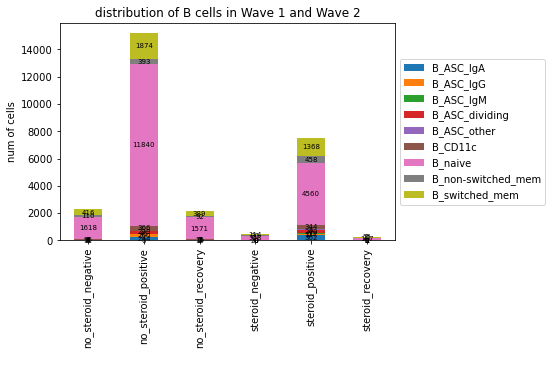

In [13]:
import matplotlib.pyplot as plt
p1=df.plot(x='wave', kind='bar', stacked=True,
        title='distribution of B cells in Wave 1 and Wave 2')
p1.set_ylabel("num of cells")
p1.set_xlabel(" ")
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in p1.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        p1.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',rotation=0,size=7)  

In [14]:
# subset to only steroid pos
steroid_pos_only = wave2[wave2.obs['steroid_status'] == 'steroid_positive'].copy()

In [15]:
# adding dates of steroid inj for each patient
steroid_pos_only.obs['steroid_date'] = 'nan'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C146", "steroid_date"] = '22/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C139", "steroid_date"] = '07/02/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C147", "steroid_date"] = '17/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C145", "steroid_date"] = '05/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C138", "steroid_date"] = '28/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C33", "steroid_date"] = '20/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C101", "steroid_date"] = '07/01/2021'
steroid_pos_only.obs.loc[steroid_pos_only.obs["patient_id"] == "C141", "steroid_date"] = '02/02/2021'

In [16]:
tmp = steroid_pos_only.copy()
tmp.obs['sample_date'] = tmp.obs['sample_date'].astype('object')
time_from_steroid = pd.to_datetime(tmp.obs['sample_date'], format='%d/%m/%Y') - pd.to_datetime(tmp.obs['steroid_date'], format='%d/%m/%Y')

In [17]:
days_from_steroid = time_from_steroid.dt.days
days_from_steroid.min()

-10

In [18]:
steroid_pos_only.obs['days_from_steroid'] = days_from_steroid

In [19]:
df =pd.crosstab(steroid_pos_only.obs['days_from_steroid'],steroid_pos_only.obs['celltype_B_corrected'])
df

celltype_B_corrected,B_ASC_IgA,B_ASC_IgG,B_ASC_IgM,B_ASC_dividing,B_ASC_other,B_CD11c,B_naive,B_non-switched_mem,B_switched_mem
days_from_steroid,,,,,,,,,
-10,1,0,0,0,0,12,267,1,54
-8,0,0,0,0,0,7,126,2,21
-6,7,1,0,1,0,25,100,6,34
-5,1,0,0,0,0,8,31,1,8
-4,7,0,2,2,0,11,7,3,16
-3,5,1,0,1,1,15,977,23,101
-2,2,0,0,0,0,34,174,10,44
-1,12,1,1,1,0,25,13,6,32
0,0,0,0,1,0,5,16,0,8


In [20]:
list(steroid_pos_only.obs['patient_id'].unique())

['C138', 'C101', 'C145', 'C146', 'C147', 'C33']

In [21]:
pat_df = {}
for x in list(steroid_pos_only.obs['patient_id'].unique()):
    pat = steroid_pos_only[steroid_pos_only.obs['patient_id'].isin([x])].copy()
    pat_df[x] = pd.crosstab(pat.obs['days_from_steroid'],pat.obs['celltype_B_corrected'],)
    pat_df[x].columns = pat_df[x].columns.add_categories(['days_from_steroid'])
    pat_df[x]['days_from_steroid'] = pat_df[x].index # making index into column

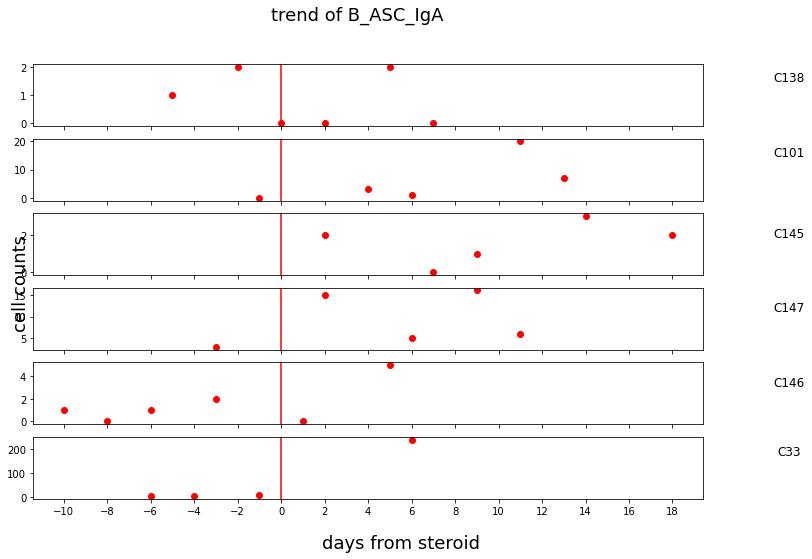

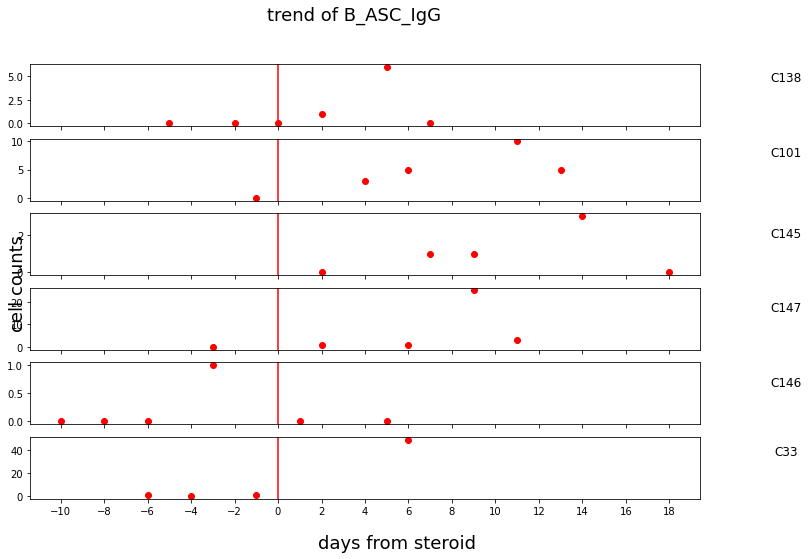

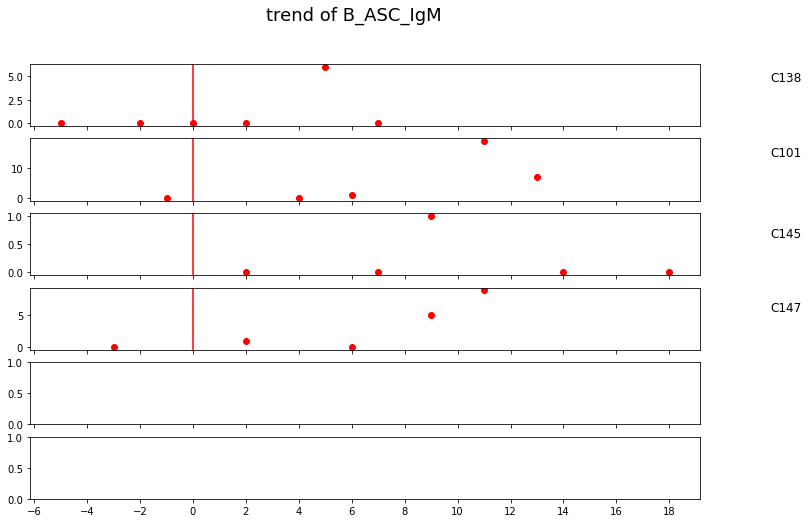

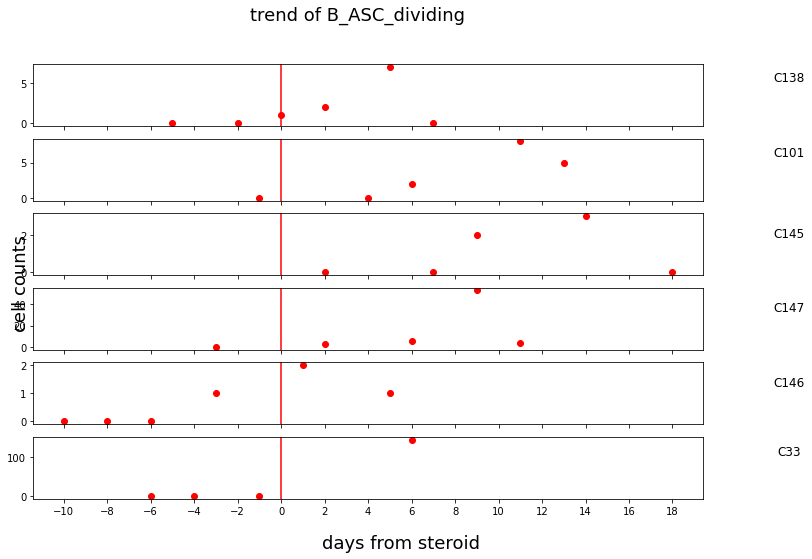

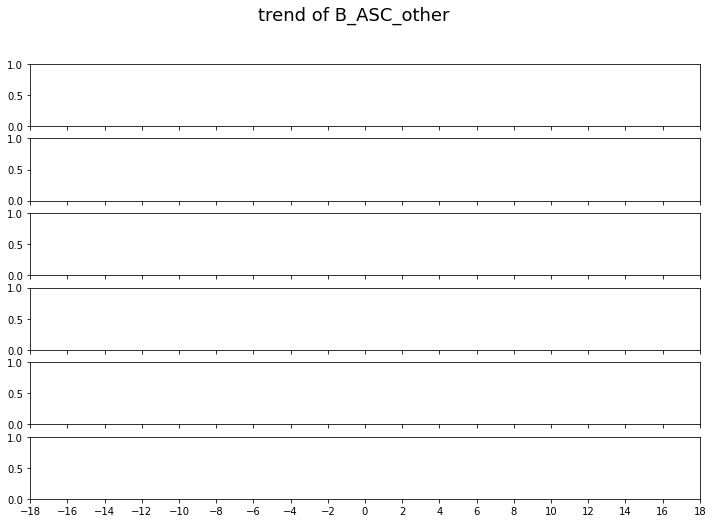

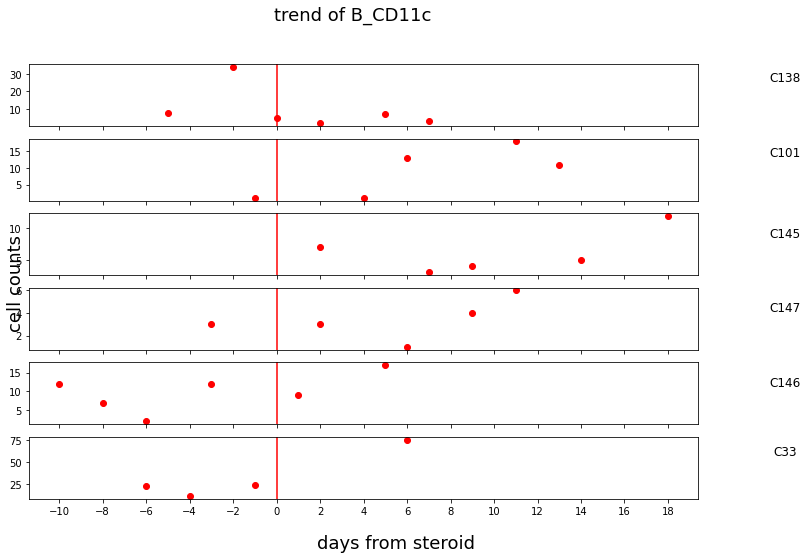

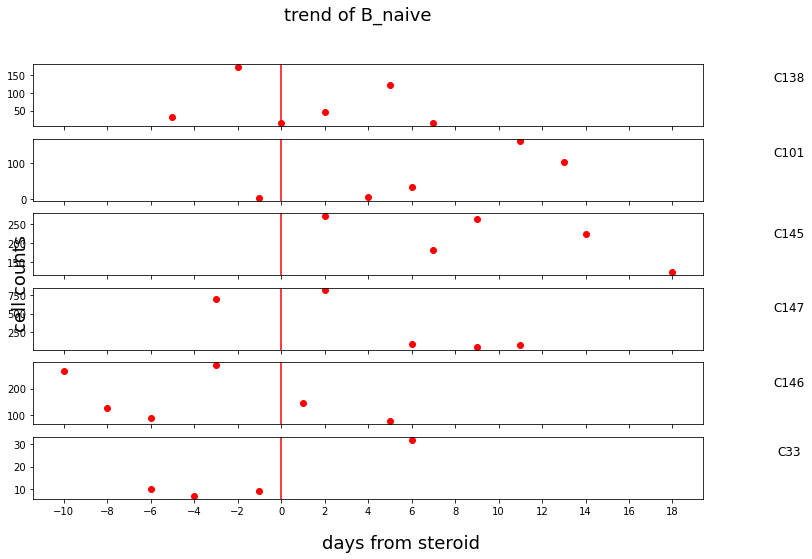

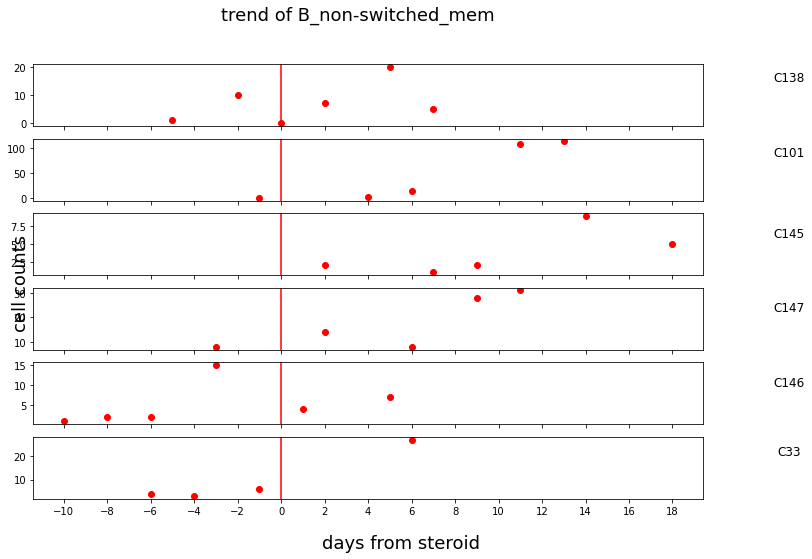

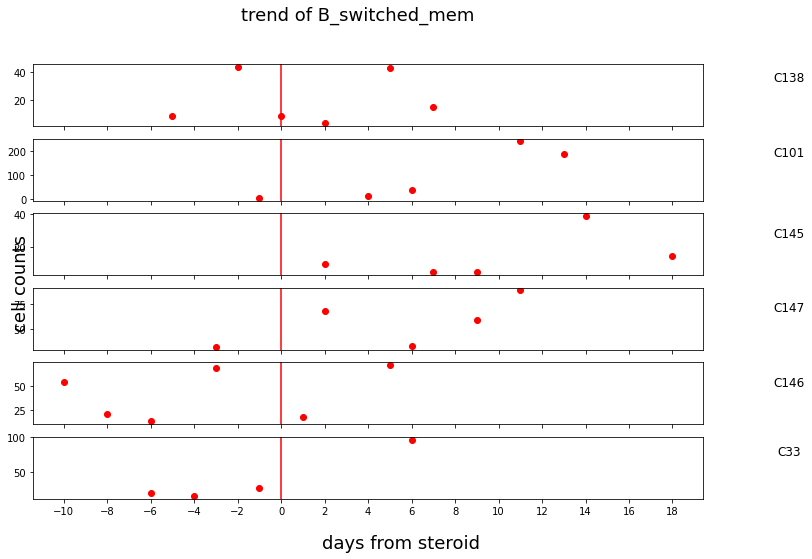

In [22]:
for celltype in df.columns:
    try:
        fig, axs = plt.subplots(nrows=6,ncols=1,sharex=True,figsize=(12,8))
        fig.suptitle('trend of ' + celltype,fontsize=18)
        axs[0].set_xticks(np.arange(-18,19,2))

        axs[0].plot(pat_df['C138']['days_from_steroid'],pat_df['C138'][celltype],'o',color='red' )
        fig.text(1, 0.85, 'C138', ha='center',fontsize=12)
        axs[0].axvline(x = 0, color = 'r')
        
        axs[1].plot(pat_df['C101']['days_from_steroid'],pat_df['C101'][celltype],'o' ,color='red' )
        fig.text(1, 0.72, 'C101', ha='center',fontsize=12)
        axs[1].axvline(x = 0, color = 'r')
        
        axs[2].plot(pat_df['C145']['days_from_steroid'],pat_df['C145'][celltype], 'o',color='red' )
        fig.text(1, 0.58, 'C145', ha='center',fontsize=12)
        axs[2].axvline(x = 0, color = 'r')
        
        axs[3].plot(pat_df['C147']['days_from_steroid'],pat_df['C147'][celltype], 'o',color='red' )
        fig.text(1, 0.45, 'C147', ha='center',fontsize=12)
        axs[3].axvline(x = 0, color = 'r')
        
        axs[4].plot(pat_df['C146']['days_from_steroid'],pat_df['C146'][celltype], 'o',color='red' )
        fig.text(1, 0.32, 'C146', ha='center',fontsize=12)
        axs[4].axvline(x = 0, color = 'r')
        
        axs[5].plot(pat_df['C33']['days_from_steroid'],pat_df['C33'][celltype], 'o',color='red' )
        fig.text(1, 0.2, 'C33', ha='center',fontsize=12)
        axs[5].axvline(x = 0, color = 'r')
        
        fig.text(0.55, 0.04, 'days from steroid', ha='center',fontsize=18)
        fig.text(0.1, 0.5, 'cell counts', va='center', rotation='vertical',fontsize=18)
    except:
        pass

In [23]:
os.makedirs('figures/steroid', exist_ok = True)

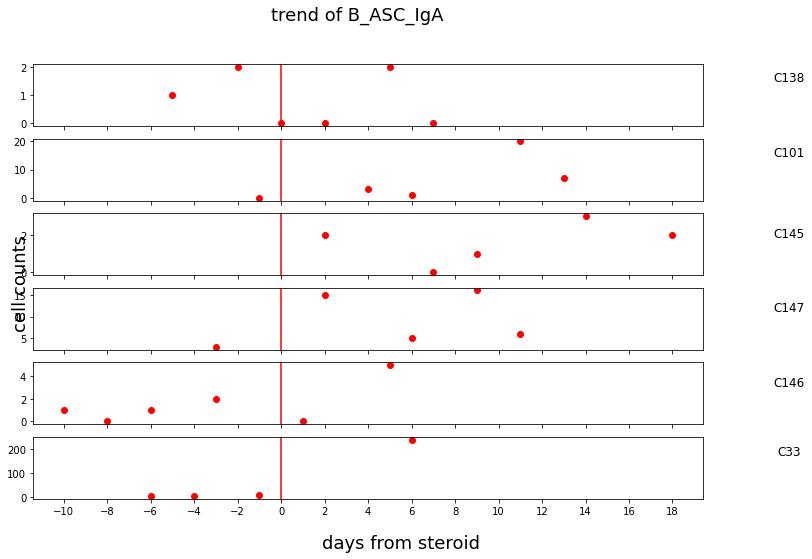

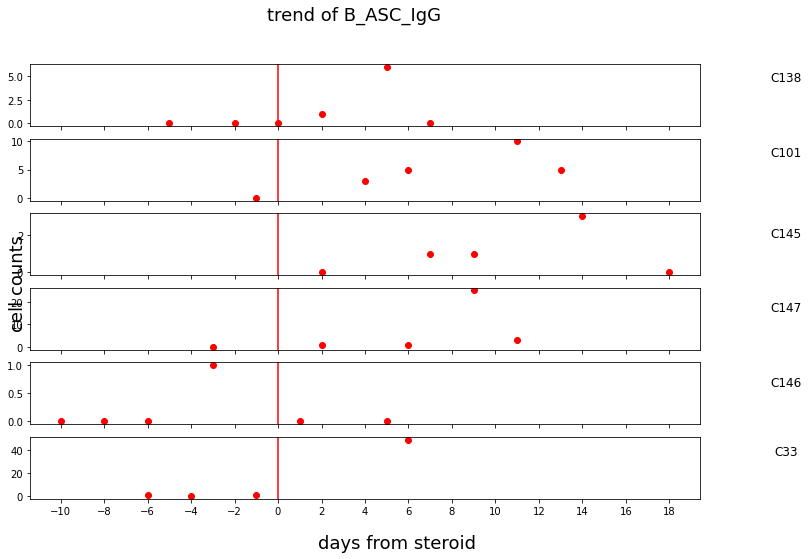

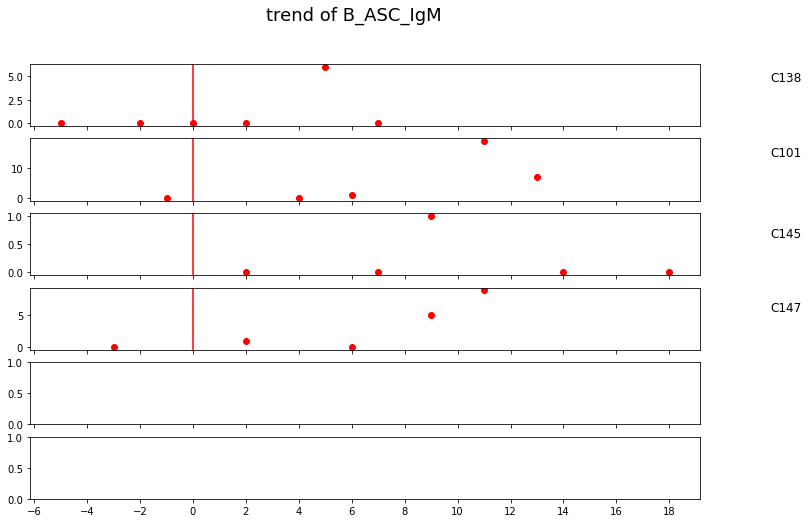

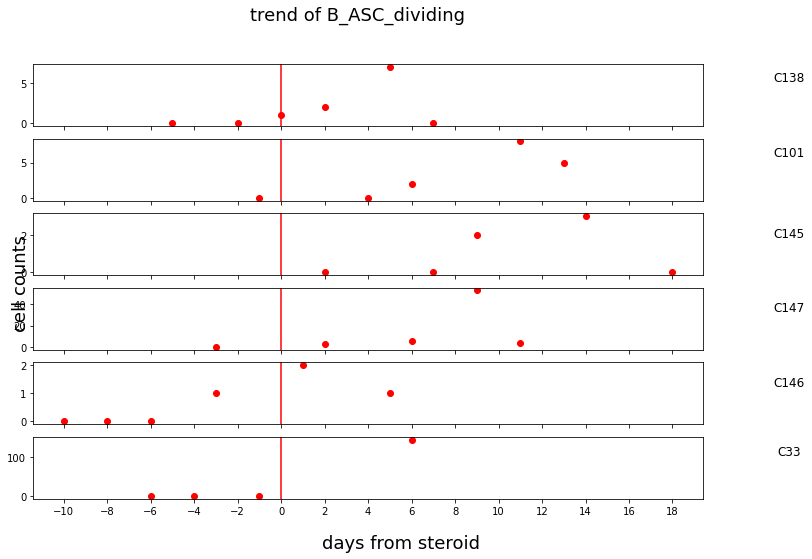

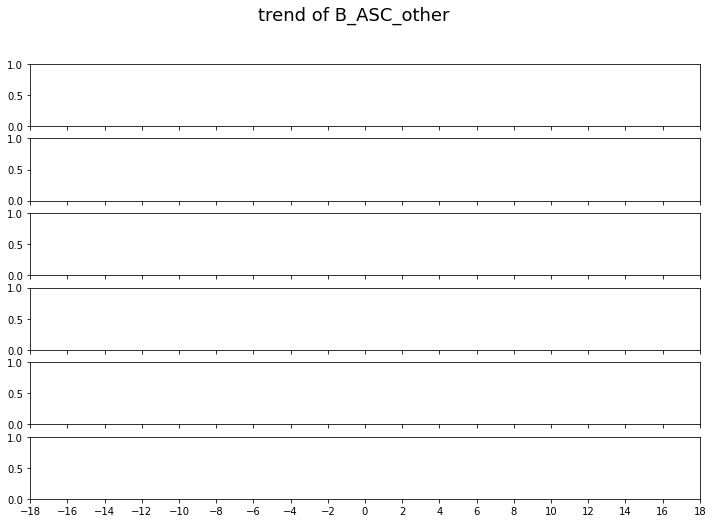

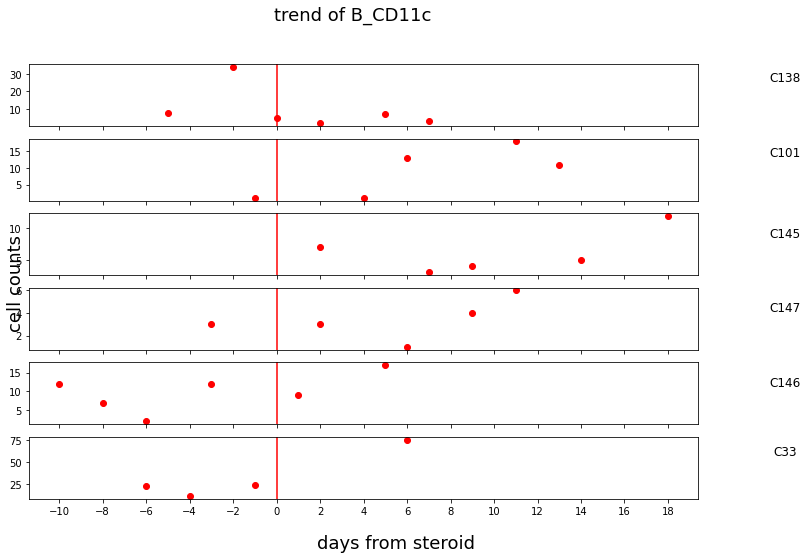

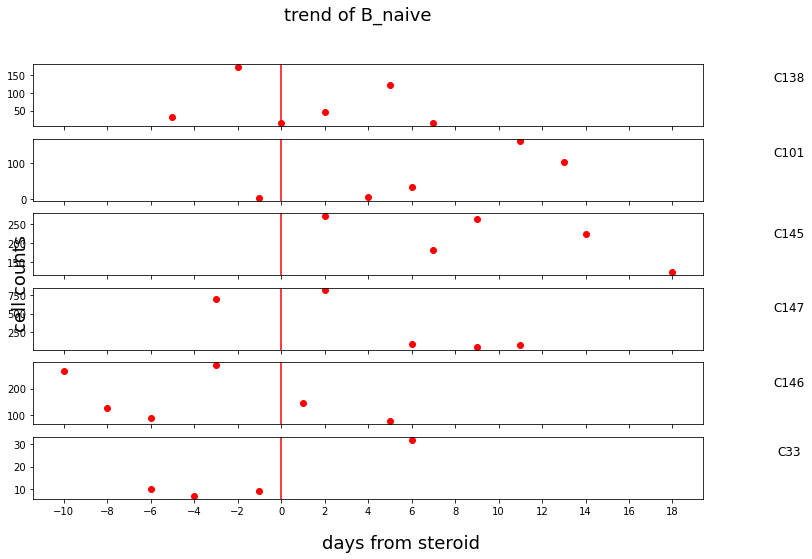

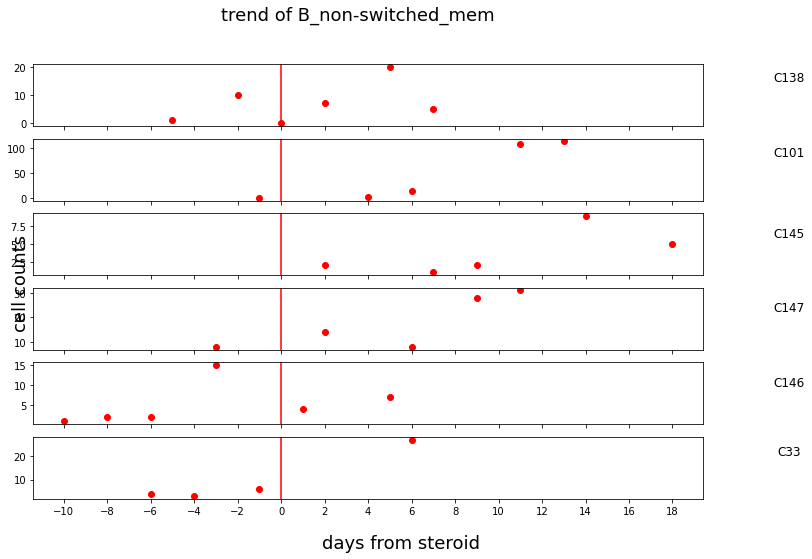

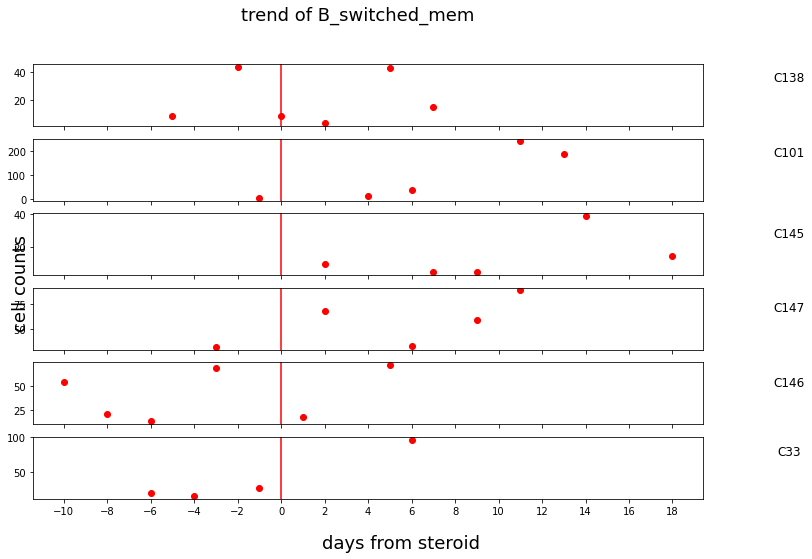

In [24]:
for celltype in df.columns:
    try:
        fig, axs = plt.subplots(nrows=6,ncols=1,sharex=True,figsize=(12,8))
        fig.suptitle('trend of ' + celltype,fontsize=18)
        axs[0].set_xticks(np.arange(-18,19,2))

        axs[0].plot(pat_df['C138']['days_from_steroid'],pat_df['C138'][celltype],'o',color='red' )
        fig.text(1, 0.85, 'C138', ha='center',fontsize=12)
        axs[0].axvline(x = 0, color = 'r')
        
        axs[1].plot(pat_df['C101']['days_from_steroid'],pat_df['C101'][celltype],'o' ,color='red' )
        fig.text(1, 0.72, 'C101', ha='center',fontsize=12)
        axs[1].axvline(x = 0, color = 'r')
        
        axs[2].plot(pat_df['C145']['days_from_steroid'],pat_df['C145'][celltype], 'o',color='red' )
        fig.text(1, 0.58, 'C145', ha='center',fontsize=12)
        axs[2].axvline(x = 0, color = 'r')
        
        axs[3].plot(pat_df['C147']['days_from_steroid'],pat_df['C147'][celltype], 'o',color='red' )
        fig.text(1, 0.45, 'C147', ha='center',fontsize=12)
        axs[3].axvline(x = 0, color = 'r')
        
        axs[4].plot(pat_df['C146']['days_from_steroid'],pat_df['C146'][celltype], 'o',color='red' )
        fig.text(1, 0.32, 'C146', ha='center',fontsize=12)
        axs[4].axvline(x = 0, color = 'r')
        
        axs[5].plot(pat_df['C33']['days_from_steroid'],pat_df['C33'][celltype], 'o',color='red' )
        fig.text(1, 0.2, 'C33', ha='center',fontsize=12)
        axs[5].axvline(x = 0, color = 'r')
        
        fig.text(0.55, 0.04, 'days from steroid', ha='center',fontsize=18)
        fig.text(0.1, 0.5, 'cell counts', va='center', rotation='vertical',fontsize=18)
        plt.savefig('figures/steroid/' + celltype + '_steriod.pdf')
    except:
        pass

In [25]:
for pt in pat_df:
    cols = list(pat_df[pt].columns)
    cols = cols[:-1]
    pat_df[pt][cols] = pat_df[pt][cols].div(pat_df[pt][cols].sum(axis=1), axis=0).multiply(100)

<ipython-input-28-6613f496daa1>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axs.plot(pat_df['C138']['days_from_steroid'],pat_df['C138'][celltype],'-o',color='red',linestyle=':' )
<ipython-input-28-6613f496daa1>:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axs.plot(pat_df['C101']['days_from_steroid'],pat_df['C101'][celltype],'-o' ,color='#a3a148',linestyle=':')
<ipython-input-28-6613f496daa1>:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axs.plot(pat_df['C145']['days_from_steroid'],pat_df['C145'][celltype], 'o-',color='purple',linestyle=':' )
<ipython-input-28-6613f496daa1>:20: UserWarning: linestyle is r

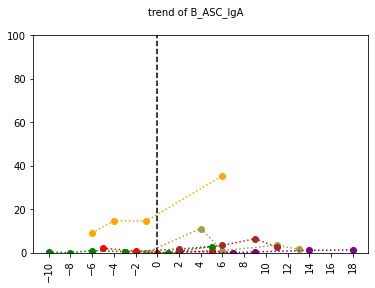

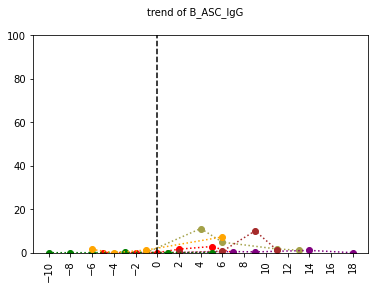

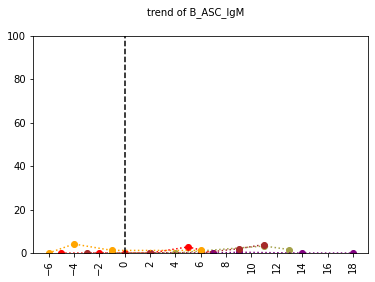

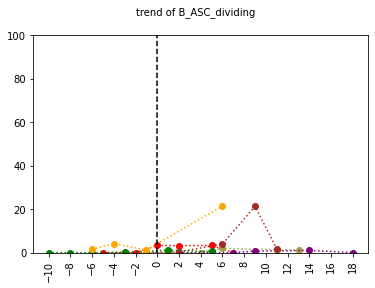

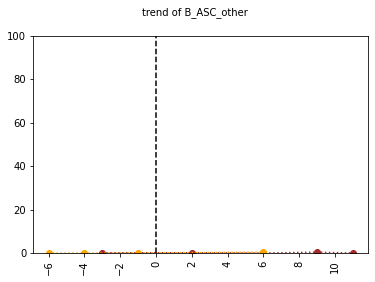

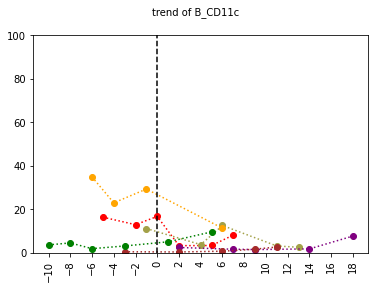

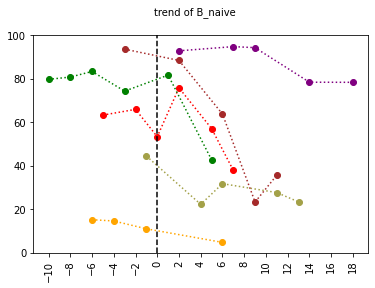

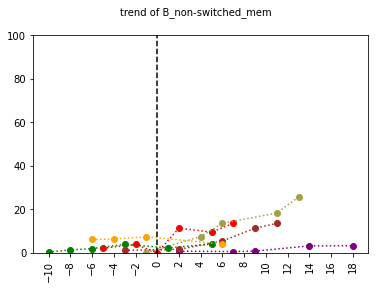

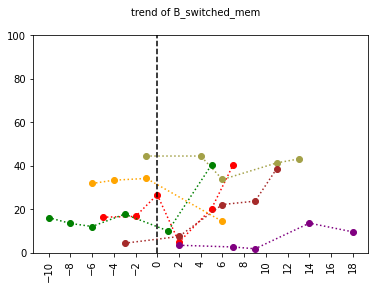

In [28]:
for celltype in df.columns:
    try:
        fig, axs = plt.subplots(figsize=(6,4))
        fig.suptitle('trend of '+ celltype,fontsize=10)
        axs.set_xticks(np.arange(-18,19,2))
        
        try:
            axs.plot(pat_df['C138']['days_from_steroid'],pat_df['C138'][celltype],'-o',color='red',linestyle=':' )
        except:
            pass
        try:
            axs.plot(pat_df['C101']['days_from_steroid'],pat_df['C101'][celltype],'-o' ,color='#a3a148',linestyle=':')
        except:
            pass
        try:
            axs.plot(pat_df['C145']['days_from_steroid'],pat_df['C145'][celltype], 'o-',color='purple',linestyle=':' )
        except:
            pass
        try:
            axs.plot(pat_df['C147']['days_from_steroid'],pat_df['C147'][celltype], 'o-',color='brown',linestyle=':' )
        except:
            pass
        try:
            axs.plot(pat_df['C146']['days_from_steroid'],pat_df['C146'][celltype], 'o-',color='green',linestyle=':' )
        except:
            pass
        try:
            axs.plot(pat_df['C33']['days_from_steroid'],pat_df['C33'][celltype], 'o-',color='orange' ,linestyle=':')
        except:
            pass
        plt.axvline(x = 0, color = 'black',linestyle='--')
        plt.ylim(0,100)
        # plt.legend(['C138','C101','C145','C147','C146','C33'], handlelength=3,fontsize=10)
        plt.xticks(rotation=90,fontsize=10)
        plt.yticks(fontsize=10)
        plt.savefig('figures/steroid/' + celltype + '_steriod_v2.pdf')
        plt.show()
    except:
        pass